In [1]:
%load_ext autoreload
%autoreload 2

# 1. Create dataset
Use Sam to extract proposals from input images (100 images) then for proposals with same regions as the ground truth masks, they are considered as positive sameple to the templates ( use the BlenderProc 42 templates), negative otherwise

Run through 100 images - then return positive proposals and negative proposals

Use IoU >0.5 to get the postive proposals

## 1.1 Extract positive proposals (the same ones as gt mask)

In [38]:
from src.model.constrastive_learning import extract_dataset

dataset="icbin"
data_type="test"
scene_id=1
pos_proposals, neg_proposals = extract_dataset(dataset, data_type, scene_id) # Take 2.21 minutes

[2024-08-13 17:38:40,528] [INFO] src.model.constrastive_learning: loading sam
[2024-08-13 17:38:40,529] [INFO] root: Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything
[2024-08-13 17:38:43,667] [INFO] root: Init CustomSamAutomaticMaskGenerator done!
[2024-08-13 17:38:46,557] [INFO] src.model.constrastive_learning: For frame 000000.png, the best for 0th mask is at index 3 with an IoU of 0.884139219808456
[2024-08-13 17:38:46,588] [INFO] src.model.constrastive_learning: For frame 000000.png, the best for 1th mask is at index 29 with an IoU of 0.8490939977349944
[2024-08-13 17:38:46,619] [INFO] src.model.constrastive_learning: For frame 000000.png, the best for 2th mask is at index 30 with an IoU of 0.7815985130111525
[2024-08-13 17:38:46,650] [INFO] src.model.constrastive_learning: For frame 000000.png, the best for 3th mask is at index 55 with an IoU of 0.8901230861603122
[2024-08-13 17:38:46,680] [INFO] src.model.constrastive_learning: For frame 000000.png, the

In [63]:
all_pos_proposals = [item for sublist in pos_proposals for item in sublist]
all_neg_proposals = [item for sublist in neg_proposals for item in sublist]

In [69]:
all_pos_proposals[0]["pose"][None].shape

(1, 4, 4)

## 1.2 Create psotive and neagtive pairs
Positive pairs (positive proposal and template with most similar pose)

In [39]:
import glob
import numpy as np
from PIL import Image


template_paths = "datasets/bop23_challenge/datasets/templates_pyrender/icbin_720/obj_obj_000001/*.png"
template_poses_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin_720/obj_poses.npy"

template_paths = sorted(glob.glob(template_paths))
template_poses = np.load(template_poses_path)

templates = {
    "rgb" : [np.array(Image.open(template_path).convert("RGB")) for template_path in template_paths],
    "poses" : template_poses
}

In [35]:
# import matplotlib.pyplot as plt
# plt.imshow(templates["rgb"][0])
# template_paths

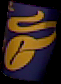

In [102]:
all_neg_proposals[2]

# 2. Process dataset
Build train_dataset as postive, negative pairs
Then build train_loader

Organize your images into classes. You'll need positive pairs (same class) and negative pairs (different classes) for training.
Resize/pad image to 224*224  then /255.0
then transform the image (also with std, mean as in ImageNet)

In [ ]:
from src.model.constrastive_learning import PairedDataset

# Custom dataset for paired images

# 3. Model

Two Approaches

    Extract features from Dinov2 as in cnos
    
    Extract BoW vectors as in FoundPose


In [ ]:
from src.model.constrastive_learning import ContrastiveModel

model = ContrastiveModel()


# 4. Implement contrastive loss function


In [23]:
# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

NameError: name 'nn' is not defined

# 5. Create data pairs for training


# 6. Train the model

# 7. Nhap

In [ ]:
# def pose_similarity(given_pose, poses):
#     R_given, t_given = np.array(given_pose[:3, :3]), np.array(given_pose[:3, 3])
#     similarities = []

#     for idx, pose in enumerate(poses):
#         R, t = np.array(pose[:3, :3]), np.array(pose[:3, 3])
        
#         # Calculate Euclidean distance for translation
#         translation_dist = np.linalg.norm(t_given - t)
        
#         # Calculate Frobenius norm for rotation
#         rotation_dist = np.linalg.norm(R_given - R, ord='fro')

#         # Total similarity measure (you can adjust the weights if needed)
#         total_dist = translation_dist + rotation_dist
#         similarities.append((total_dist, idx))

#     # Sort by similarity (lower distance means more similar)
#     similarities.sort()

#     return similarities

# given_pose = pos_proposals[0][0]["pose"]
# poses = templates["poses"]
# similarity_scores = pose_similarity(given_pose, poses)
# top_5_similar = similarity_scores[:5]

In [ ]:
# from scipy.spatial.distance import cdist
# from scipy.spatial.transform import Rotation
# import matplotlib.pyplot as plt

# def compute_inplane(rot_query_openCV, rot_template_openCV):
#     delta = rot_template_openCV.dot(rot_query_openCV.T)
#     inp = extract_inplane_from_pose(delta)
#     # double check to make sure that reconved rotation is correct
#     R_inp = convert_inplane_to_rotation(inp)
#     recovered_R1 = R_inp.dot(rot_template_openCV)
#     err = geodesic_numpy(recovered_R1, rot_query_openCV)
#     if err >= 15:
#         print("WARINING, error of recovered pose is >=15, err=", err)
#     return inp

# def opencv2opengl(cam_matrix_world):
#     transform = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#     if len(cam_matrix_world.shape) == 2:
#         return np.matmul(transform, cam_matrix_world)
#     else:
#         transform = np.tile(transform, (cam_matrix_world.shape[0], 1, 1))
#         return np.matmul(transform, cam_matrix_world)

# def extract_inplane_from_pose(pose):
#     inp = Rotation.from_matrix(pose).as_euler("zyx", degrees=True)[0]
#     return inp

# def convert_inplane_to_rotation(inplane):
#     R_inp = Rotation.from_euler("z", -inplane, degrees=True).as_matrix()
#     return R_inp

# def geodesic_numpy(R1, R2):
#     theta = (np.trace(R2.dot(R1.T)) - 1) / 2
#     theta = np.clip(theta, -1, 1)
#     return np.degrees(np.arccos(theta))

# def extract_positive_pairs(all_pos_proposals)
#     pos_pairs = list()
#     for proposals_id in range(len(all_pos_proposals)):
#         obj_query_pose = all_pos_proposals[proposals_id]["pose"][None]
#         obj_template_poses = templates["poses"]

#         return_inplane = True

#         obj_query_openGL_pose = opencv2opengl(obj_query_pose)
#         obj_query_openGL_location = obj_query_openGL_pose[:, 2, :3]  # Mx3 # (translation components) -  It assumes that the 3D location is found in the third column of the pose matrices.
#         obj_template_openGL_poses = opencv2opengl(obj_template_poses)
#         obj_template_openGL_locations = obj_template_openGL_poses[:, 2, :3]  # Nx3 # (translation components)

#         # find the nearest template
#         # It computes the pairwise distances between each query pose location and each template pose location using cdist.
#         distances = cdist(obj_query_openGL_location, obj_template_openGL_locations)
#         best_index_in_pose_distribution = np.argmin(distances, axis=-1)  # M
#         if return_inplane:
#             nearest_poses = obj_template_poses[best_index_in_pose_distribution]
#             inplanes = np.zeros(len(obj_query_pose))
#             for idx in range(len(obj_query_pose)):
#                 rot_query_openCV = obj_query_pose[idx, :3, :3]
#                 rot_template_openCV = nearest_poses[idx, :3, :3]
#                 inplanes[idx] = compute_inplane(rot_query_openCV, rot_template_openCV)
#         #     return self.avail_index[best_index_in_pose_distribution], inplanes #  self.avail_index is just the index from 0 to 42

#         pos_pair = {
#             "img1" : templates["rgb"][best_index_in_pose_distribution[0]],
#             "img2" : all_pos_proposals[proposals_id]["rgb"],
#             "label" : 1
#         }
#         pos_pairs.append(pos_pair)
#         # plt.figure(figsize=(10, 5))
#         # plt.subplot(1, 2, 1)
#         # plt.imshow(templates["rgb"][best_index_in_pose_distribution[0]])
#         # plt.axis('off')

#         # plt.subplot(1, 2, 2)
#         # plt.imshow(all_pos_proposals[proposals_id]["rgb"])
#         # plt.axis('off')

#         # plt.show()
#     return pos_pairs